# **Install and Import Requierd Library**

In [3]:
!pip install keras.utils

In [4]:
!pip install lime

In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

2024-06-25 15:58:58.858329: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 15:58:58.858389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 15:58:58.860074: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Load the dataset**

In [7]:
df = pd.read_excel('/kaggle/input/dataset-for-sentiment/dataset (1).xlsx')

In [8]:
df.head()

,Text,Sentiment
0,আপনারা নিতে পারেন ভালো কাজ করে আমি ব্যাবহার কর...,1.0
1,এক কথায় অসাধারণ একটা জিনিস। আগে অনেক রিমুভার ...,1.0
2,অনেক ভালো লাগছে ❤️ যেমন টা চেয়েছি তেমনটাই পেলা...,1.0
3,অনেক ভালো কাজ করে!,1.0
4,তবে যদি দাম টা আর একটু কম হতো তো মনে হয় আরো ভা...,0.0


In [9]:
print("Show Null Value in Dataset")
print("--------------------------")
df.isnull().sum()

Show Null Value in Dataset
--------------------------


Text         15
Sentiment    20
dtype: int64

In [10]:
print("Show Duplicate Value in Dataset")
print("--------------------------")
df.duplicated().sum()

Show Duplicate Value in Dataset
--------------------------


201

In [11]:
def dataPreprocessing(df):
  #1. Remove null value
  df.dropna(inplace=True,subset=['Text'])
  print("Null Value Remove Successfully....")

  #2. Remove Duplicate value
  df.drop_duplicates(inplace=True)
  print("Duplicate Value Remove Successfully....")

  #3. Remove Non-Character Word(like emoji)
  df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^\u0980-\u09FF\s]+', '', x))
  print("Non-Character Word Remove Successfully....")

  #4. Remove Non Bengali Character
  bengali_pattern = re.compile("[\u0980-\u09FF ]+")
  df['Bengali_Text'] = df['Text'].apply(lambda x: "".join(filter(bengali_pattern.match, x)))
  print("Non bengali Character Remove Successfully....")

  #5. Removing stopwords
  def process_conversations(Conversation):
    stp = open('/kaggle/input/dataset-for-sentiment/bangla_stopwords (1).txt','r',encoding="utf8").read().split()
    result = Conversation.split()
    Conversation = [word.strip() for word in result if word not in stp ]
    Conversation =" ".join(Conversation)
    Conversation = re.sub('[^\u0980-\u09FF]',' ',str(Conversation))
    return Conversation
  df['cleaned'] = df['Bengali_Text'].apply(process_conversations)
  print("Stopwords Remove Successfully....")

  #remove the small Sentence
  df['no_char'] = df['cleaned'].apply(lambda Sentence: len(Sentence))
  df['length'] = df['cleaned'].apply(lambda x:len(x.split()))
  df = df.sort_values(by='length', ascending=False)
  dataset = df.loc[df.length>2]
  dataset = dataset.reset_index(drop = True)
  print("After Cleaning:","\nRemoved {} Small conversations".format(len(df)-len(dataset)),
      "\nTotal conversations:",len(dataset))

  #Remove Big Sentence
  df = dataset.loc[dataset['length'] <= 200]
  df = df.reset_index(drop = True)
  print("After Cleaning:","\nRemoved {} Big conversations".format(len(dataset)-len(df)),
      "\nTotal conversations:",len(df))

In [12]:
dataPreprocessing(df)

Null Value Remove Successfully....
Duplicate Value Remove Successfully....
Non-Character Word Remove Successfully....
Non bengali Character Remove Successfully....
Stopwords Remove Successfully....
After Cleaning: 
Removed 469 Small conversations 
Total conversations: 4216
After Cleaning: 
Removed 0 Big conversations 
Total conversations: 4216


In [13]:
df.dropna(subset=['Sentiment'], inplace=True)

In [14]:
print("Show Null Value in Dataset After Data Preprocessing")
print("---------------------------------------------------")
df.isnull().sum()

Show Null Value in Dataset After Data Preprocessing
---------------------------------------------------


Text            0
Sentiment       0
Bengali_Text    0
cleaned         0
no_char         0
length          0
dtype: int64

In [15]:
df.drop_duplicates(inplace=True)

In [16]:
print("Show Duplicate Value in Dataset After Data Preprocessing")
print("--------------------------------------------------------")
df.duplicated().sum()

Show Duplicate Value in Dataset After Data Preprocessing
--------------------------------------------------------


0

In [17]:
df.sample(5)

,Text,Sentiment,Bengali_Text,cleaned,no_char,length
3240,এক কথায় অসাধারণ ছবিটা দিতে পারলাম না নিশ্চিন...,1.0,এক কথায় অসাধারণ ছবিটা দিতে পারলাম না নিশ্চিন...,এক কথায় অসাধারণ ছবিটা পারলাম নিশ্চিন্তে আপনার...,52,8
2058,দামটা বেশি নিয়েছে মনে হচ্ছে তবে এক্সাক্ট কাজ হ...,1.0,দামটা বেশি নিয়েছে মনে হচ্ছে তবে এক্সাক্ট কাজ হ...,দামটা নিয়েছে এক্সাক্ট হয়নিতে ডেলিভারি চার্জ ফ্...,79,12
3776,প্রথমে ভেবেছিলাম সুতি পরে দেখি জার্সি কাপড় তবু...,1.0,প্রথমে ভেবেছিলাম সুতি পরে দেখি জার্সি কাপড় তবু...,প্রথমে ভেবেছিলাম সুতি দেখি জার্সি কাপড় তবুও দা...,72,11
711,দারাজ কে অসংখ্য ধন্যবাদ পোডাক্টা সঠিক সময়ে হাত...,1.0,দারাজ কে অসংখ্য ধন্যবাদ পোডাক্টা সঠিক সময়ে হাত...,দারাজ অসংখ্য ধন্যবাদ পোডাক্টা সঠিক সময়ে হাতে প...,51,8
740,আমি রিটার্ন চাই,0.0,আমি রিটার্ন চাই,রিটার্ন চাই,11,2


In [18]:
df.drop(["Text", "Bengali_Text", "no_char", "length"], axis=1, inplace=True)
df.dropna(subset=['Sentiment'], inplace=True)

In [19]:
df.sample(5)

,Sentiment,cleaned
1831,1.0,দারাজ প্রোডাক্ট ক্রয় করেছি কোনদিন মন্তব্য আজক...
3132,1.0,ধন্যবাদ তাঁতঘরকেশাড়িটা সুন্দর আম্মুর পছন্দ হয়ছ...
1765,1.0,অল্প সময়ের ডেলিভারি পেয়েছি চট্টগ্রামে
98,1.0,প্রোডাক্ট দ্রুতই হাতে পেয়েছি ভালোভাবেই হাতে প...
1437,1.0,ধন্যবাদ ভালো প্রডাকট দেওয়ার


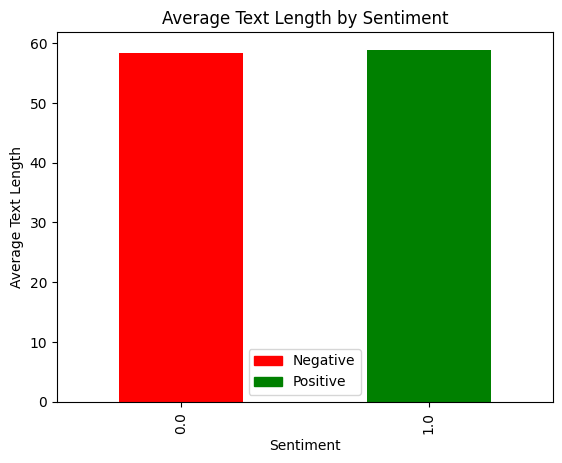

In [20]:
df['length'] = df['cleaned'].apply(len)

# Group by sentiment and calculate mean length
df.groupby('Sentiment')['length'].mean().plot(kind='bar', color=['red', 'green'])

# Plot the bar chart

plt.title('Average Text Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Text Length')

# Add legend
# Create a list of labels for the legend
labels = ['Negative', 'Positive']

# Create a list of handles (empty rectangles) for the legend
handles = [plt.Rectangle((0,0),1,1, color=color) for color in ['red', 'green']]

# Add the legend to the plot
plt.legend(handles, labels)

plt.show()

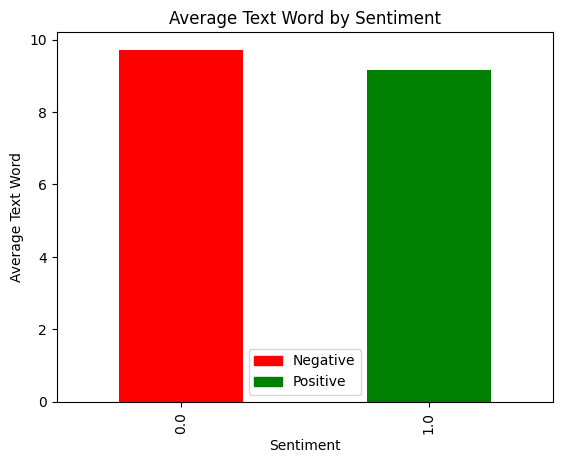

In [21]:
# prompt: Average Text Word by Sentiment

import matplotlib.pyplot as plt
df['word_count'] = df['cleaned'].apply(lambda x: len(str(x).split()))

# Group by sentiment and calculate mean word count
df.groupby('Sentiment')['word_count'].mean().plot(kind='bar', color=['red', 'green'])

# Plot the bar chart

plt.title('Average Text Word by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Text Word')

# Add legend
# Create a list of labels for the legend
labels = ['Negative', 'Positive']

# Create a list of handles (empty rectangles) for the legend
handles = [plt.Rectangle((0,0),1,1, color=color) for color in ['red', 'green']]

# Add the legend to the plot
plt.legend(handles, labels)

plt.show()


In [22]:
from collections import Counter

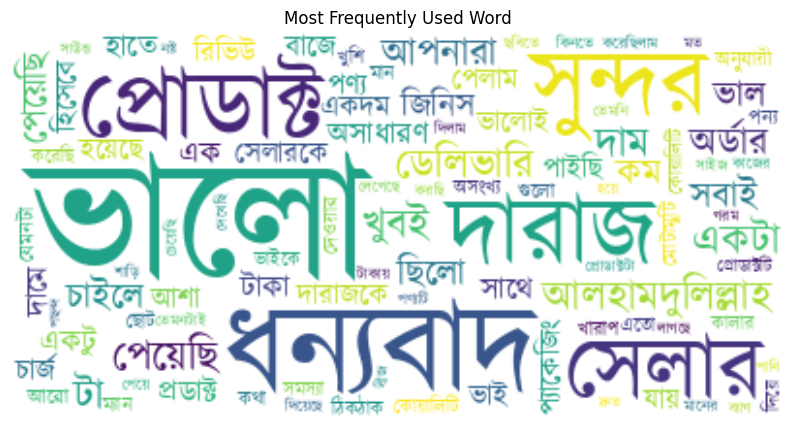

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming you have a dataframe named df with a column named 'text' containing the text data
# Replace 'text' with the actual column name containing your text data

# Concatenate all text data into a single string
text = ' '.join(df['cleaned'])
words = text.split()
word_counts = Counter(words)
top_words = word_counts.most_common(100)
word_freq_dict = {word: freq for word, freq in top_words}
# Create a word cloud object
wordcloud = WordCloud(font_path='/kaggle/input/font-family/kalpurush.ttf', colormap='viridis',background_color="white").generate_from_frequencies(word_freq_dict)


# Display the word cloud using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most Frequently Used Word')
plt.axis('off')
plt.show()

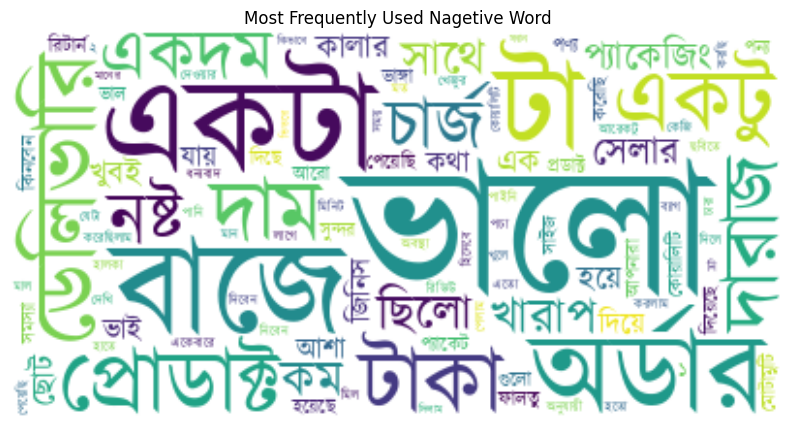

In [24]:
filtered_df = df[df['Sentiment'] == 0]
text = ' '.join(filtered_df['cleaned'])
words = text.split()
word_counts = Counter(words)
top_words = word_counts.most_common(100)
word_freq_dict = {word: freq for word, freq in top_words}
wordcloud = WordCloud(font_path='/kaggle/input/font-family/kalpurush.ttf', colormap='viridis',background_color="white").generate_from_frequencies(word_freq_dict)


# Display the word cloud using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequently Used Nagetive Word')
plt.show()

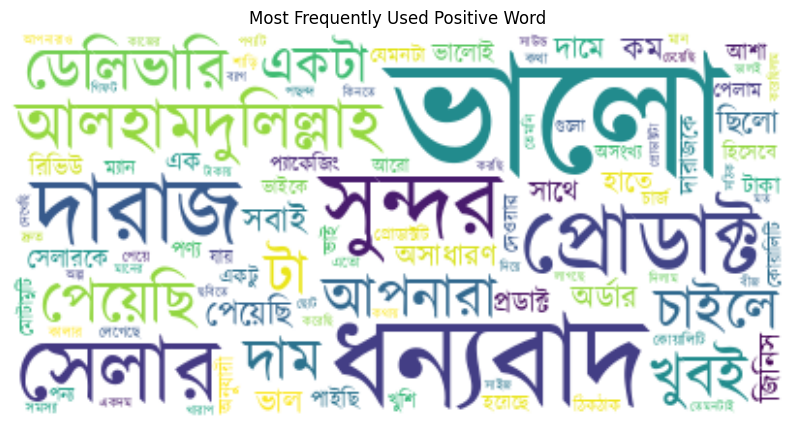

In [25]:
filtered_df = df[df['Sentiment'] == 1]
text = ' '.join(filtered_df['cleaned'])
words = text.split()
word_counts = Counter(words)
top_words = word_counts.most_common(100)
word_freq_dict = {word: freq for word, freq in top_words}
wordcloud = WordCloud(font_path='/kaggle/input/font-family/kalpurush.ttf', colormap='viridis',background_color="white").generate_from_frequencies(word_freq_dict)


# Display the word cloud using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequently Used Positive Word')
plt.show()

In [26]:
texts = df['cleaned'].values
labels = df['Sentiment'].values

In [27]:
# Split data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test= train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [28]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [29]:
# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [30]:
# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print("Vocabolary Size: ", vocab_size)

Vocabolary Size:  5884


In [31]:
# Pad sequences to ensure uniform input length
maxlen = 100
X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)
X_val_pad = pad_sequences(X_val_seq, padding='post', maxlen=maxlen)

# CNN Architecture

In [32]:
# Define the model architecture
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=256, input_length=maxlen))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = model.fit(X_train_pad, y_train, epochs=20, batch_size=64, validation_data=(X_val_pad, y_val))

Epoch 1/20
39/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6908 - loss: 0.5930

I0000 00:00:1719331156.339921    1871 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.7106 - loss: 0.5745 - val_accuracy: 0.7939 - val_loss: 0.4144
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8344 - loss: 0.3443 - val_accuracy: 0.8617 - val_loss: 0.3342
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9528 - loss: 0.1501 - val_accuracy: 0.8631 - val_loss: 0.3816
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9829 - loss: 0.0657 - val_accuracy: 0.8602 - val_loss: 0.4377
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9900 - loss: 0.0412 - val_accuracy: 0.8559 - val_loss: 0.5284
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9880 - loss: 0.0373 - val_accuracy: 0.8617 - val_loss: 0.5601
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9924 - loss: 0.0275 - val_accuracy: 0.8530 - val_loss: 0.5995
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9939 - loss: 0.0232 - val_accuracy: 0.8617 - val_loss: 0.6278
Ep

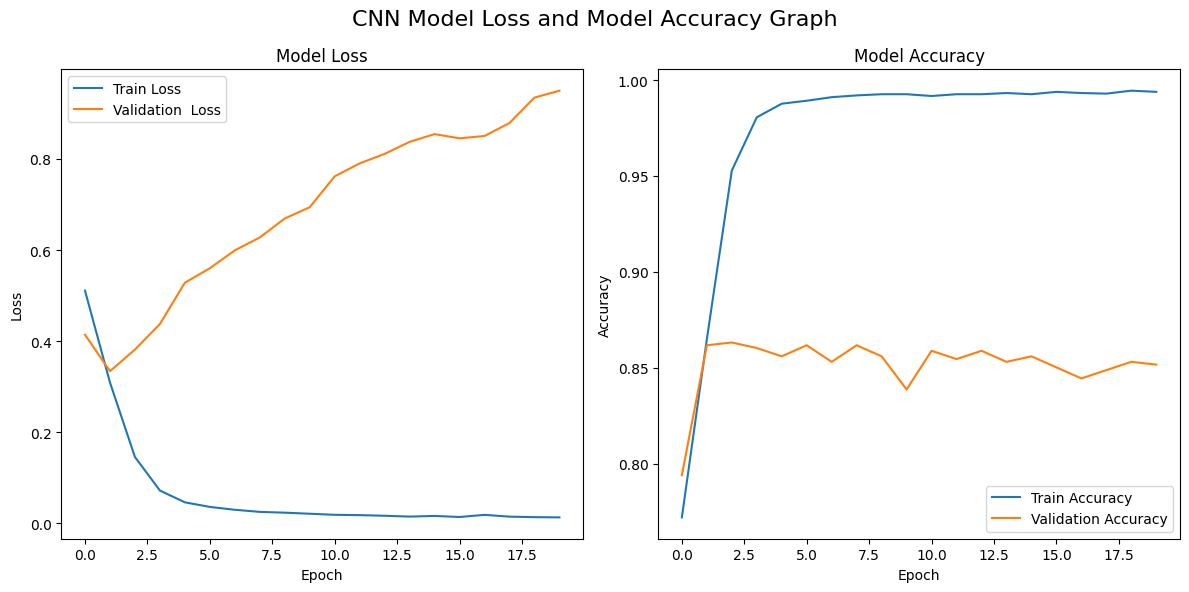

In [34]:
import matplotlib.pyplot as plt

# Assuming you have already trained a model and have the history object


# Extract the loss and validation loss from the history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract the accuracy and validation accuracy from the history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a figure with two subplots

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the loss and validation loss
ax1.plot(loss)
ax1.plot(val_loss)
ax1.set_title('Model Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Train Loss', 'Validation  Loss'])

# Plot the accuracy and validation accuracy
ax2.plot(accuracy)
ax2.plot(val_accuracy)
ax2.set_title('Model Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Train Accuracy', 'Validation Accuracy'])

# Show the plots
fig.suptitle("CNN Model Loss and Model Accuracy Graph", fontsize=16)
plt.tight_layout()
plt.show()

In [35]:
loss_and_metrics = model.evaluate(X_train_pad,y_train,batch_size=64)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(X_test_pad,y_test,batch_size=64)
print("The test accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(X_val_pad,y_val,batch_size=64)
print("The validation accuracy is: "+str(loss_and_metrics[1]))

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9946 - loss: 0.0095
The train accuracy is: 0.9947530627250671
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8897 - loss: 0.7835
The test accuracy is: 0.8848921060562134
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8464 - loss: 0.9225 
The validation accuracy is: 0.8515850305557251


In [36]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test_pad)
y_pred_binary = np.argmax(y_pred, axis=1)  # Get the class with highest probability
report = classification_report(y_test, y_pred_binary, target_names=["Negative", "Positive"])
print(report)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
              precision    recall  f1-score   support

    Negative       0.81      0.58      0.68       144
    Positive       0.90      0.96      0.93       551

    accuracy                           0.88       695
   macro avg       0.85      0.77      0.80       695
weighted avg       0.88      0.88      0.88       695



22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


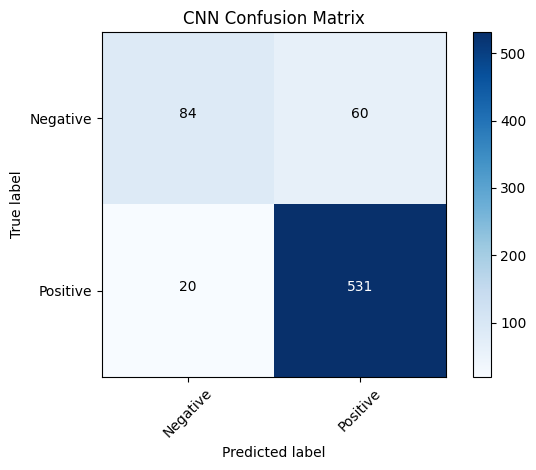

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Example usage
# Assuming y_true contains true labels and y_pred contains predicted labels

# Get the predictions for the test set
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1) # Convert predictions to binary format (0 or 1)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_classes) # Use y_pred_classes instead of y_pred_binary
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Negative", "Positive"], title='CNN Confusion Matrix')
plt.show()

In [38]:
from lime.lime_text import LimeTextExplainer

# Choose a text to explain
text_to_explain = "সত্যি শাড়িটা অসাধারণ।  দামের তুলনায় অনেক ভালো একটা শাড়ি। সবাই নিতে পারেন। আমার অনেক পছন্দ হয়েছে।  ডেলিভারিও খুব তাড়াতাড়ি পেয়ে গেছ"
# Function to predict with the model
def predict_proba(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    X_pred = pad_sequences(sequences, maxlen=50)
    # Use 'predict' instead of 'predict_proba' and extract probabilities
    return model.predict(X_pred)

# Initialize LIME Text Explainer
explainer = LimeTextExplainer(class_names=['Negative', 'Positive'])

# Explain the prediction
explanation = explainer.explain_instance(text_to_explain, predict_proba, num_features=10, top_labels=1)

# Display the most important features
explanation.show_in_notebook(text=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


# LSTM

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Layer

In [40]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]), initializer='uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],), initializer='uniform', trainable=True)
        self.u = self.add_weight(name='att_u', shape=(input_shape[-1],), initializer='uniform', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        uit = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        ait = tf.tensordot(uit, self.u, axes=1)
        a = tf.nn.softmax(ait, axis=1)
        a = tf.expand_dims(a, axis=-1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

In [41]:
# Define the model architecture
input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen)(input_layer)
lstm_layer = LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)
attention_layer = Attention()(lstm_layer)
dense_layer = Dense(64, activation='relu')(attention_layer)
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(2, activation='softmax')(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 100, 128)       │       753,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 128)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 909,762 (3.47 MB)

 Trainable params: 909,762 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
history = model.fit(X_train_pad, y_train, epochs=20, batch_size=64, validation_data=(X_test_pad, y_test))


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.7850 - loss: 0.5492 - val_accuracy: 0.7928 - val_loss: 0.5024
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.7865 - loss: 0.5029 - val_accuracy: 0.8475 - val_loss: 0.3853
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.8821 - loss: 0.2983 - val_accuracy: 0.8633 - val_loss: 0.3597
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9365 - loss: 0.1940 - val_accuracy: 0.8374 - val_loss: 0.4169
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9579 - loss: 0.1379 - val_accuracy: 0.8647 - val_loss: 0.4457
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9749 - loss: 0.0971 - val_accuracy: 0.8576 - val_loss: 0.5057
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.9760 - loss: 0.0866 - val_accuracy: 0.8302 - val_loss: 0.5405
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9854 - loss: 0.0625 - val_accuracy: 0

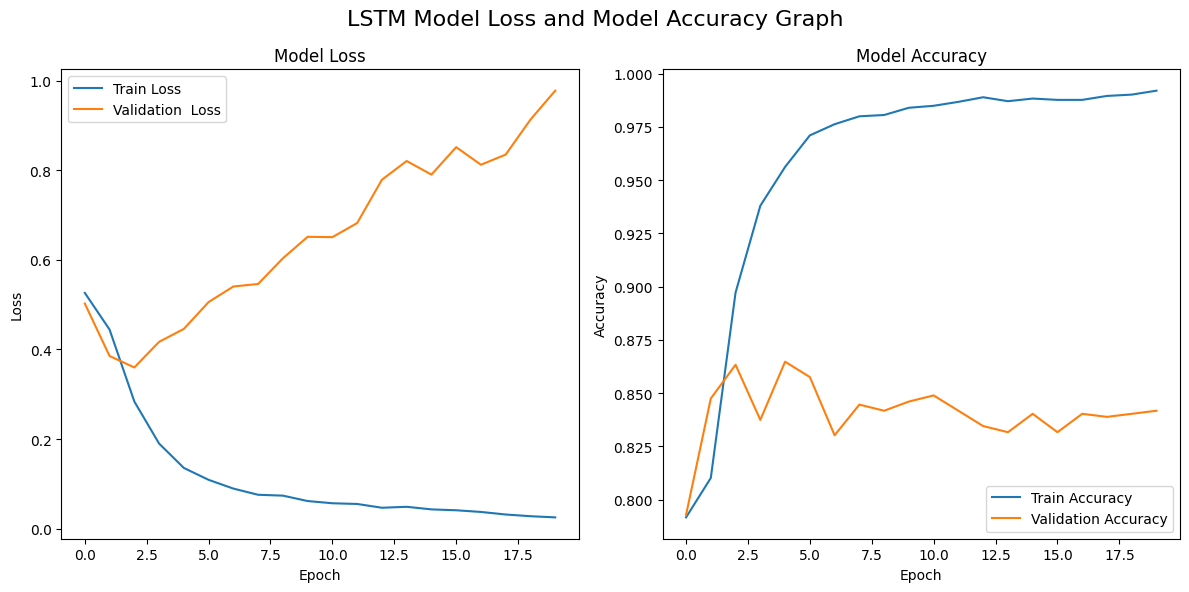

In [43]:
import matplotlib.pyplot as plt

# Assuming you have already trained a model and have the history object


# Extract the loss and validation loss from the history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract the accuracy and validation accuracy from the history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a figure with two subplots

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the loss and validation loss
ax1.plot(loss)
ax1.plot(val_loss)
ax1.set_title('Model Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Train Loss', 'Validation  Loss'])

# Plot the accuracy and validation accuracy
ax2.plot(accuracy)
ax2.plot(val_accuracy)
ax2.set_title('Model Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Train Accuracy', 'Validation Accuracy'])

# Show the plots
fig.suptitle("LSTM Model Loss and Model Accuracy Graph", fontsize=16)
plt.tight_layout()
plt.show()

In [44]:
loss_and_metrics = model.evaluate(X_train_pad,y_train,batch_size=64)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(X_test_pad,y_test,batch_size=64)
print("The test accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(X_val_pad,y_val,batch_size=64)
print("The validation accuracy is: "+str(loss_and_metrics[1]))

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9923 - loss: 0.0184
The train accuracy is: 0.9916666746139526
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8561 - loss: 0.9309
The test accuracy is: 0.8417266011238098
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8337 - loss: 0.9057
The validation accuracy is: 0.8342939615249634


In [45]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test_pad)
y_pred_binary = np.argmax(y_pred, axis=1)  # Get the class with highest probability
report = classification_report(y_test, y_pred_binary, target_names=["Negative", "Positive"])
print(report)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
              precision    recall  f1-score   support

    Negative       0.65      0.50      0.57       144
    Positive       0.88      0.93      0.90       551

    accuracy                           0.84       695
   macro avg       0.77      0.72      0.74       695
weighted avg       0.83      0.84      0.83       695



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


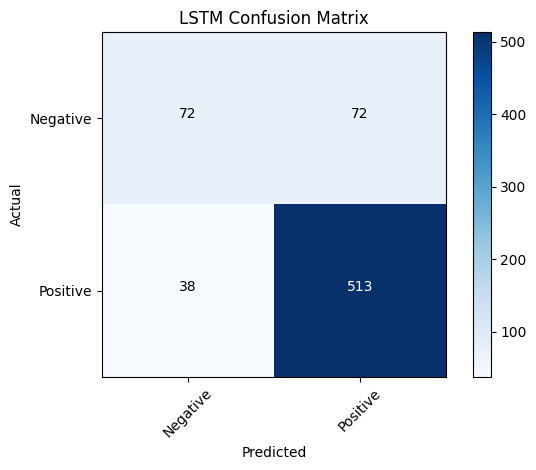

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()

# Example usage
# Assuming y_true contains true labels and y_pred contains predicted labels

# Get the predictions for the test set
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1) # Convert predictions to binary format (0 or 1)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_classes) # Use y_pred_classes instead of y_pred_binary
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Negative", "Positive"], title='LSTM Confusion Matrix')
plt.show()

# Bi-LSTM

In [47]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.sequence import pad_sequences

In [48]:
# Define the model architecture
input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen)(input_layer)
conv_layer = Conv1D(filters=64, kernel_size=5, activation='relu')(embedding_layer)
pooling_layer = GlobalMaxPooling1D()(conv_layer)
bi_lstm_layer = Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(embedding_layer)
attention_layer = Attention()(bi_lstm_layer)
concat_layer = tf.keras.layers.concatenate([attention_layer, pooling_layer])
dense_layer = Dense(64, activation='relu')(concat_layer)
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(2, activation='softmax')(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 100, 128)  │    753,152 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 100, 256)  │    263,168 │ embedding_2[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 96, 64)    │     41,024 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 256)       │     66,048 │ bidirectional[0]… │
│ (Attention)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 320)       │          0 │ attention_1[0][0… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     20,544 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2)         │        130 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,144,066 (4.36 MB)

 Trainable params: 1,144,066 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
history = model.fit(X_train_pad, y_train, epochs=20, batch_size=64, validation_data=(X_val_pad, y_val))

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 271ms/step - accuracy: 0.7836 - loss: 0.5472 - val_accuracy: 0.7939 - val_loss: 0.4537
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 229ms/step - accuracy: 0.7986 - loss: 0.4092 - val_accuracy: 0.8545 - val_loss: 0.3403
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step - accuracy: 0.9373 - loss: 0.2107 - val_accuracy: 0.8703 - val_loss: 0.3523
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 240ms/step - accuracy: 0.9759 - loss: 0.0858 - val_accuracy: 0.8516 - val_loss: 0.4073
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 249ms/step - accuracy: 0.9868 - loss: 0.0554 - val_accuracy: 0.8545 - val_loss: 0.4690
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 245ms/step - accuracy: 0.9880 - loss: 0.0417 - val_accuracy: 0.8516 - val_loss: 0.5446
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 240ms/step - accuracy: 0.9943 - loss: 0.0217 - val_accuracy: 0.8530 - val_loss: 0.5651
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 244ms/step - accuracy: 0.9915 - loss: 0.0300 - val_accu

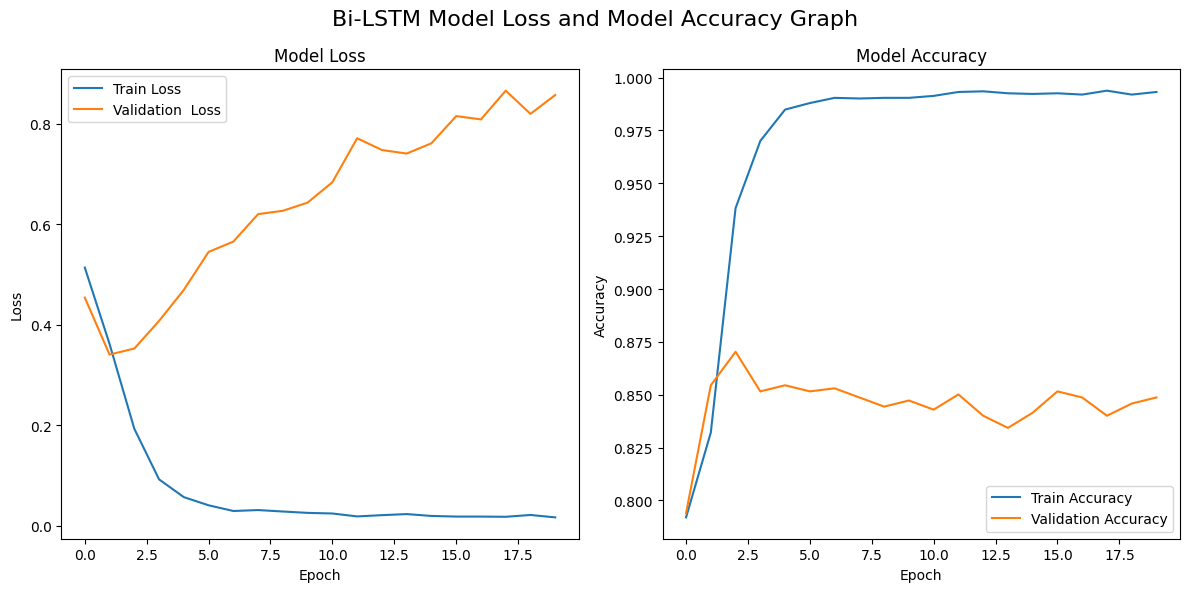

In [50]:
import matplotlib.pyplot as plt

# Assuming you have already trained a model and have the history object


# Extract the loss and validation loss from the history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract the accuracy and validation accuracy from the history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a figure with two subplots

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the loss and validation loss
ax1.plot(loss)
ax1.plot(val_loss)
ax1.set_title('Model Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Train Loss', 'Validation  Loss'])

# Plot the accuracy and validation accuracy
ax2.plot(accuracy)
ax2.plot(val_accuracy)
ax2.set_title('Model Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Train Accuracy', 'Validation Accuracy'])

# Show the plots
fig.suptitle("Bi-LSTM Model Loss and Model Accuracy Graph", fontsize=16)
plt.tight_layout()
plt.show()

In [51]:
loss_and_metrics = model.evaluate(X_train_pad,y_train,batch_size=64)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(X_test_pad,y_test,batch_size=64)
print("The test accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(X_val_pad,y_val,batch_size=64)
print("The validation accuracy is: "+str(loss_and_metrics[1]))

51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9943 - loss: 0.0112
The train accuracy is: 0.9941357970237732
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8734 - loss: 0.6616
The test accuracy is: 0.861870527267456
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8512 - loss: 0.7967
The validation accuracy is: 0.848703145980835


In [52]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test_pad)
y_pred_binary = np.argmax(y_pred, axis=1)  # Get the class with highest probability
report = classification_report(y_test, y_pred_binary, target_names=["Negative", "Positive"])
print(report)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step
              precision    recall  f1-score   support

    Negative       0.68      0.63      0.65       144
    Positive       0.91      0.92      0.91       551

    accuracy                           0.86       695
   macro avg       0.79      0.78      0.78       695
weighted avg       0.86      0.86      0.86       695



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


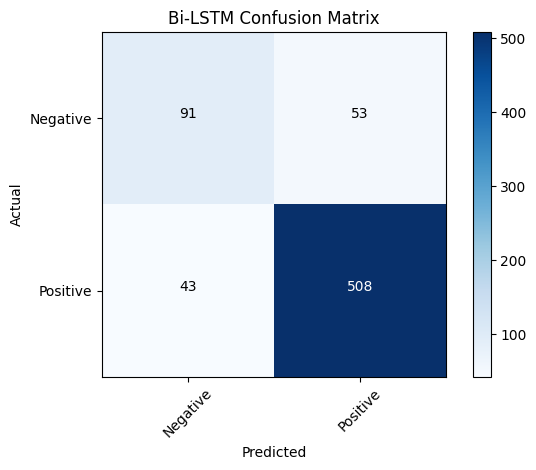

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()

# Example usage
# Assuming y_true contains true labels and y_pred contains predicted labels

# Get the predictions for the test set
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1) # Convert predictions to binary format (0 or 1)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_classes) # Use y_pred_classes instead of y_pred_binary
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Negative", "Positive"], title='Bi-LSTM Confusion Matrix')
plt.show()